In [1]:
import gym

In [2]:
env = gym.make('Taxi-v3')

In [3]:
env.reset()

328

In [4]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



There are 4 locations (labeled by different letters) and your job is to pick up the passenger at one location and drop him off in another. You receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions.

- The filled square represents the taxi, which is yellow without a passenger and green with a passenger.
- The pipe ("|") represents a wall which the taxi cannot cross.
- R, G, Y, B are the possible pickup and destination locations. 
    - The blue letter represents the current passenger pick-up location, 
    - the purple letter is the current destination.

What should be done:
1. move to Blue location
2. pickup
3. move to Purple (Cyan) location
4. drop-off

In [5]:
action = 0
r = env.step(action)
print(r)
env.render()

(428, -1, False, {'prob': 1.0})
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


In [6]:
env.action_space  # the number of actions

Discrete(6)

In [7]:
env.observation_space  # the number of observations

Discrete(500)

- the 500 states correspond to encodings of the taxi's location, the passenger's location, and the destination location.
-     state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)

In [8]:
def decode(state):
    ss = ['taxi_row', 'taxi_col', 'passenger_loc', 'dest']
    return [k for k in zip(ss, env.decode(state))]

In [9]:
state = env.reset()
env.render()
print( decode(state) )

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

[('taxi_row', 2), ('taxi_col', 2), ('passenger_loc', 2), ('dest', 1)]


In [10]:
state, reward, done, info = env.step(1)
decode(state)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


## State Transition Dynamics $P$

`P[state]` gives a dictionary of action dynamics:
`{action: [(probability, nextstate, reward, done)]}`

In [11]:
state = env.reset()
env.render()
print('state: ', state)
print('decoded state: ', decode(state))
print(f'P[{state}]', env.P[state])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

state:  434
decoded state:  [('taxi_row', 4), ('taxi_col', 1), ('passenger_loc', 3), ('dest', 2)]
P[434] {0: [(1.0, 434, -1, False)], 1: [(1.0, 334, -1, False)], 2: [(1.0, 454, -1, False)], 3: [(1.0, 434, -1, False)], 4: [(1.0, 434, -10, False)], 5: [(1.0, 434, -10, False)]}


In [12]:
env.P[state]

{0: [(1.0, 434, -1, False)],
 1: [(1.0, 334, -1, False)],
 2: [(1.0, 454, -1, False)],
 3: [(1.0, 434, -1, False)],
 4: [(1.0, 434, -10, False)],
 5: [(1.0, 434, -10, False)]}

- action map

DOWN = 0
UP = 1
RIGHT = 2
LEFT = 3
PICKUP = 4
DROPOFF = 5

## Let's see what happens with the environment.

In [13]:
state = env.reset()

steps = 0
G = 0  # total return

frames = [] # for animation, see next cell

done = False

while not done:
    action = env.action_space.sample()              # randome action choice
    state, reward, done, info = env.step(action)    # apply action

    G += reward
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    steps += 1
#
print(f'Last reward: {reward}\nTotal Steps: {steps}\nTotal Return: {G}')

Last reward: -1
Total Steps: 200
Total Return: -686


### Two Rendering Modes

In [14]:
env.render(mode='human')

+---------+
|R:_| : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)


In [15]:
env.render()

+---------+
|R:_| : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)


In [16]:
env.render(mode='ansi')

'+---------+\n|R:\x1b_\x1b| : :\x1bG\x1b|\n| : | : : |\n| : : : : |\n| | : | : |\n|Y| : |B: |\n+---------+\n  (East)\n'

Use `print()` to get proper visual display of the output.

In [17]:
print(frames[0]['frame'])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



In [18]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames, repeat=1, pause=2.):
    while repeat > 0:
        G = 0
        for i, frame in enumerate(frames):
            G += frame['reward']
            clear_output(wait=True)
            print(frame['frame'])
            print(f"Timestep: {i + 1}")
            print(f"State: {frame['state']}")
            print(f"Action: {frame['action']}")
            print(f"Reward: {frame['reward']}  {G}")
            sleep(.1)
        repeat -= 1
    sleep(pause)
#     

In [19]:
print_frames(frames)

+---------+
|R:_| : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Timestep: 200
State: 37
Action: 2
Reward: -1  -686


## Q-Learning
- Update action-value function $Q(s,a)$ step by step on-line.
$$
    Q(s, a) = (1-\alpha) Q(s, a) + \alpha\big(r + \gamma \max_{a'} Q(s', a') \big)
$$

Algorithm:

1. Initialize Q
1. Choose an action A.
1. Apply action A. From current state S, travel to the next state S'. Observer reward R.
1. Update Q-table
1. Repeat

Assumption:
- The observation from the environment is equivalent to state S.

In [20]:
# How many states do we have?
n_states = env.observation_space.n  # == len(env.P)  
n_actions = env.action_space.n 
print('n_states: ', n_states)
print('n_actions: ', n_actions)

n_states:  500
n_actions:  6


In [42]:
import numpy as np 

# 1. initialize Q table
Q = np.zeros((n_states, n_actions), dtype=float)

### Learning Iteration

In [43]:
# %%time 
# training the agent (Q table)

from IPython.display import clear_output 

# hyper parameters
alpha = 0.1
gamma = 0.9
epsilon = 0.1 

n_iters = 10000
rng = np.random.default_rng(2021)
Glist, nstepsList = [], []
for iter in range(n_iters):

    # start a new episode -------------------
    state = env.reset()
    done = False
    G, nsteps = 0, 0
    while not done:  # repeat until the terminal or too many wondering steps
        # 1. choose Action
        # we employ e-greedy policy
        if rng.uniform() < epsilon:  # random exploration
            action = rng.integers(low=0, high=n_actions)
        else:                    # greedy action
            action = np.argmax(Q[state])  # Q[s] gives an array of action values of size n_actions
        #
        # 2. Move
        obs, reward, done, info = env.step(action)

        # 3. Update
        q_next = Q[obs]
        max_q = np.max(q_next)

        Q[state, action] = (1 - alpha) * Q[state, action] \
                               + alpha * ( reward + gamma * max_q )
        #
        # 4. step forward
        state = obs 
        nsteps += 1 
        G += reward 
    # end of episode -----------------------
    Glist.append(G)
    nstepsList.append(nsteps)

    if iter % 100 == 0:
        clear_output(wait=True)
        print(f'Episode: {iter}, G: {G} {nsteps}')
# end of learning
print('Finished.')

Episode: 9900, G: 8 13
Finished.


Let's check the Q table learned.

In [23]:
def pr_action():
    print('0: down, 1: up, 2: left, 3: right, 4: pickup, 5: drop-off')

In [24]:
state = env.reset()
env.render()
pr_action()
Q[state]

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

0: down, 1: up, 2: left, 3: right, 4: pickup, 5: drop-off


array([-3.59791978, -3.30154774,  0.45991652, -3.65104581, -5.94598953,
       -4.72556247])

In [25]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Let's test the learning by following $A = arg\max_a Q[S, a]$ at every state $S$.

In [30]:
def greedy_action(qtable, S):
    q = qtable[S]
    a = np.argmax(q)
    return a 

def run(env, verbose=True):
    state = env.reset()

    steps = 0
    G = 0  # total return

    frames = [] # for animation, see next cell
    done = False

    while not done:
        action = greedy_action(Q, state)              # randome action choice
        state, reward, done, info = env.step(action)    # apply action

        G += reward
    
        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )

        steps += 1
    #
    if verbose:
        print(f'Last reward: {reward}\nTotal Steps: {steps}\nTotal Return: {G}')
    #
    return G, steps, frames
#

In [27]:
G, steps, frames = run(env)

Last reward: 20
Total Steps: 14
Total Return: 7


In [28]:
print_frames(frames, repeat=10)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 14
State: 475
Action: 5
Reward: 20  7


In [29]:
# let's try another game

g, steps, frames = run(env)
print_frames(frames, repeat=5)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 8
State: 475
Action: 5
Reward: 20  13


### Learning Curves

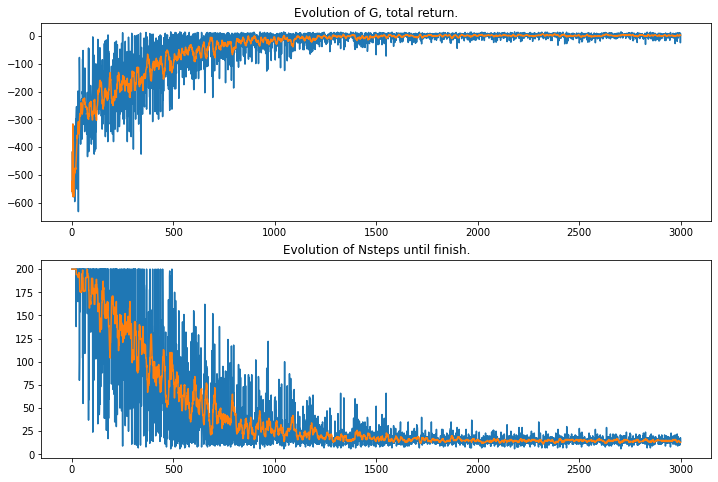

In [51]:
import matplotlib.pyplot as plt 

def moving_average(arr, tab=11):
    a = np.array(arr)
    ma = a.copy()
    for i in range(tab, len(arr)):
        ma[i] = a[i-tab:i].mean()
    return ma 

fig, axes = plt.subplots(2,1, figsize=(12,8))
n = 3000
axes[0].plot(Glist[:n]); axes[0].set(title='Evolution of G, total return.')
axes[0].plot(moving_average(Glist[:n]))
axes[1].plot(nstepsList[:n]); axes[1].set(title='Evolution of Nsteps until finish.');
axes[1].plot(moving_average(nstepsList[:n]));

### Evaluation of the learned agent's performance

In [31]:
nrepeat = 240

glist, nslist = [], []
for _ in range(nrepeat):
    g, ns, _ = run(env, verbose=False)
    glist.append(g)
    nslist.append(ns)

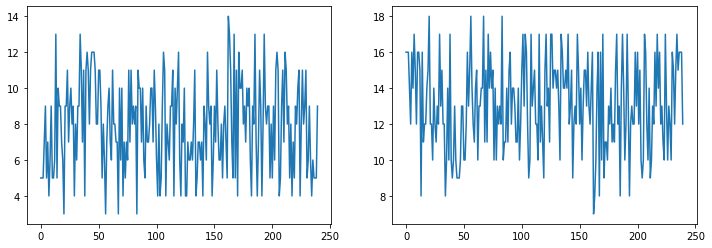

In [32]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].plot(glist);
axes[1].plot(nslist);

About the hyper-parameters

- The learning rate $\alpha$ should decrease as you continue to gain a larger and larger knowledge base.
- The exploration parameter $\epsilon$ should decrease since it is needed less and less as we learn since the policy is good enough after learning.
- Assumption is that the environment is stationary - not changing at all through time. But if it is slowly changing, we need to keep $\alpha$ and $\epsilon$ at some reasonalbe values.

Pros and Cons.

Pros

- Well it works.

Cons

- If the number of states and actions are large, it will difficult to finish learing quickly, and it may be difficult to keep the table in main memory space.

## Where to go

- Apply to other gym environments having discrete spaces.

- Apply discretization to `Mountain Car` problem to use the ready-made q-learning code. The state space of Mountain Car enviroment has continuous values (real numbers).


- You may try NN instead of table. Before delving into more interesting and complicated problems, it will give you some experience about using NN in RL.


## References

1. https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/
1. https://www.coursera.org/learn/practical-rl?ranMID=40328&ranEAID=OyHlmBp2G0c&ranSiteID=OyHlmBp2G0c-Vmlv9yIsBFjTZ9sHpM8lbQ&siteID=OyHlmBp2G0c-Vmlv9yIsBFjTZ9sHpM8lbQ&utm_content=10&utm_medium=partners&utm_source=linkshare&utm_campaign=OyHlmBp2G0c